In [1]:
# 1. Install necessary libraries
!pip install diffusers transformers accelerate huggingface_hub


In [2]:
# 2. Imports
import torch
from torch import autocast
from diffusers import DiffusionPipeline
from huggingface_hub import snapshot_download
import gc

In [3]:
import pynvml
import torch

# Initialize NVML once at the start of your notebook
pynvml.nvmlInit()

def get_gpu_metrics(device_idx=0):
    """
    Print GPU memory usage, SM utilization, and memory bandwidth utilization.
    """
    # PyTorch memory metrics
    used_mem_MB = torch.cuda.memory_allocated(device_idx) / 1024 / 1024
    reserved_mem_MB = torch.cuda.memory_reserved(device_idx) / 1024 / 1024
    total_mem_MB = torch.cuda.get_device_properties(device_idx).total_memory / 1024 / 1024

    # NVML metrics
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_idx)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    util_info = pynvml.nvmlDeviceGetUtilizationRates(handle)

    metrics = {
        "pytorch_allocated_MB": used_mem_MB,
        "pytorch_reserved_MB": reserved_mem_MB,
        "nvml_used_MB": mem_info.used / 1024 / 1024,
        "total_memory_MB": total_mem_MB,
        "memory_utilization_percent": 100 * used_mem_MB / total_mem_MB,
        "sm_utilization_percent": util_info.gpu,
        "memory_bandwidth_utilization_percent": util_info.memory
    }

    return metrics

In [4]:
# 3. Download and Load Model
model_path = snapshot_download(repo_id="cerspense/zeroscope_v2_576w")

pipe = DiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
).to("cuda")

pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))  # Disable safety checker
pipe.unet.eval()


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


UNet3DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (transformer_in): TransformerTemporalModel(
    (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
    (proj_in): Linear(in_features=320, out_features=512, bias=True)
    (transformer_blocks): ModuleList(
      (0): BasicTransformerBlock(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn1): Attention(
          (to_q): Linear(in_features=512, out_features=512, bias=False)
          (to_k): Linear(in_features=512, out_features=512, bias=False)
          (to_v): Linear(in_features=512, out_features=512, bias=False)
          (to_out): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            

In [5]:
batch_size = 1
num_frames = 8

In [6]:

prompt_list_full = [
    "A cinematic sunset over the mountains",
    "A bustling city skyline at night",
    "A peaceful forest in autumn",
    "A futuristic space station orbiting a planet",
    "A snowy village during Christmas",
    "A tropical beach at sunrise",
    "An ancient castle on a misty hill",
    "A colorful coral reef underwater",
    "A cute cat",
    "Dancing cat video",
    "Harry Potter",
    "A cute european village",
]

prompt_list = prompt_list_full[:batch_size]

# Get tokenizer and text_encoder from pipeline
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

# Tokenize prompt
text_inputs = tokenizer(
    prompt_list,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    return_tensors="pt"
)

input_ids = text_inputs.input_ids.to("cuda")


In [7]:
# Encode text
with torch.no_grad():
    encoder_hidden_states = text_encoder(input_ids)[0]  # (batch_size, seq_len, hidden_dim)


In [8]:
# 5. Prepare Static Latents and Timestep
latent_shape = (batch_size, 4, num_frames, 64, 64)

latents = torch.randn(latent_shape, device="cuda", dtype=torch.float16)
timestep = torch.tensor([50], device="cuda", dtype=torch.float16)  # Random timestep


In [9]:
# Torch Compile
pipe.unet = torch.compile(pipe.unet)

In [10]:
# 6. Warmup UNet Forward
with torch.no_grad(), autocast("cuda"):
    _ = pipe.unet(latents, timestep, encoder_hidden_states).sample

print("Warmup UNet Forward")


W0428 19:54:33.378000 30007 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Warmup UNet Forward


In [11]:
# 7. Capture UNet forward with CUDA Graph
print("Capturing UNet with CUDA Graph...")

graph = torch.cuda.CUDAGraph()

with torch.cuda.graph(graph):
    with torch.no_grad(), autocast("cuda"):
        unet_output = pipe.unet(latents, timestep, encoder_hidden_states).sample

torch.cuda.synchronize()
print("Capture complete!")


Capturing UNet with CUDA Graph...
Capture complete!


In [12]:
# 8. Replay and Profile
profile_logdir = "./graph_profile_log"

print("Profiling CUDA Graph replays...")

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

total_time_ms = 0.0
num_repeats = 10

# Warmup replay
graph.replay()
torch.cuda.synchronize()

metrics_per_step = []

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(profile_logdir),
    record_shapes=False,
    with_stack=False,
    profile_memory=False
) as prof:
    for step in range(num_repeats):
        start_event.record()

        graph.replay()
        torch.cuda.synchronize()
        # Collect and save metrics
        step_metrics = get_gpu_metrics()
        metrics_per_step.append(step_metrics)

        end_event.record()

        elapsed_time_ms = start_event.elapsed_time(end_event)
        total_time_ms += elapsed_time_ms

        torch.cuda.empty_cache()
        gc.collect()

        prof.step()

print("Profiling complete! 🚀")

avg_time_per_replay_ms = total_time_ms / num_repeats

print(f"\\n🚀 Benchmark Results:")
print(f"Batch size = {batch_size}, Num Frames = {num_frames}")
print(f"Total time for {num_repeats} replays: {total_time_ms:.2f} ms")
print(f"Average time per replay: {avg_time_per_replay_ms:.2f} ms")

Profiling CUDA Graph replays...
Profiling complete! 🚀
\n🚀 Benchmark Results:
Batch size = 1, Num Frames = 8
Total time for 10 replays: 7831.69 ms
Average time per replay: 783.17 ms


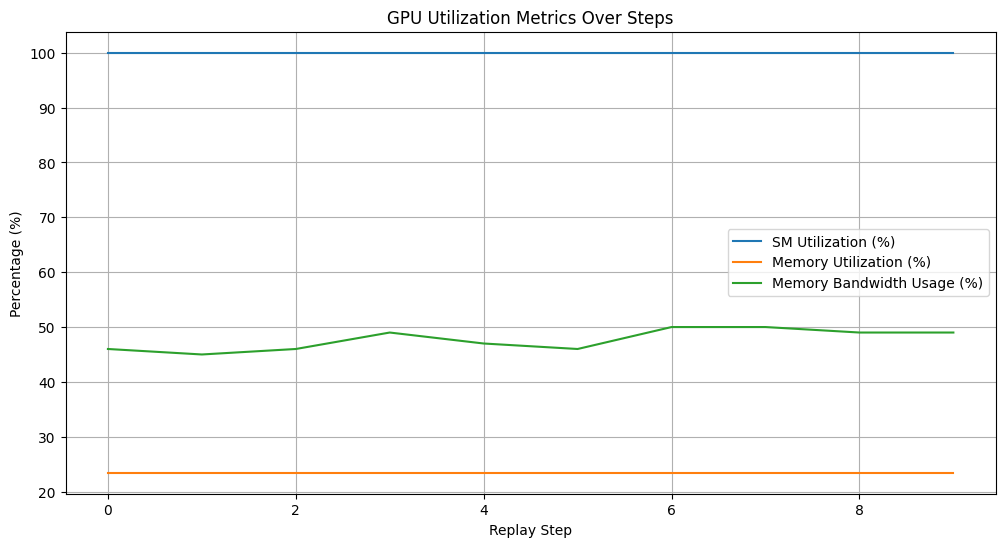

In [13]:
import matplotlib.pyplot as plt

# Extract fields
sm_utilization = [m['sm_utilization_percent'] for m in metrics_per_step]
mem_utilization = [m['memory_utilization_percent'] for m in metrics_per_step]
bandwidth_utilization = [m['memory_bandwidth_utilization_percent'] for m in metrics_per_step]

# Plot
plt.figure(figsize=(12,6))
plt.plot(sm_utilization, label='SM Utilization (%)')
plt.plot(mem_utilization, label='Memory Utilization (%)')
plt.plot(bandwidth_utilization, label='Memory Bandwidth Usage (%)')
plt.xlabel('Replay Step')
plt.ylabel('Percentage (%)')
plt.title('GPU Utilization Metrics Over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
! ls -lart {profile_logdir}

total 169408
-rw-r--r-- 1 root root 10687749 Apr 28 18:10 e3a041091f6c_300.1745863856573288064.pt.trace.json
-rw-r--r-- 1 root root 10681860 Apr 28 18:38 e3a041091f6c_8476.1745865516773837723.pt.trace.json
-rw-r--r-- 1 root root 10689357 Apr 28 18:39 e3a041091f6c_8476.1745865557483951261.pt.trace.json
-rw-r--r-- 1 root root 10681962 Apr 28 18:54 e3a041091f6c_13009.1745866494003918595.pt.trace.json
-rw-r--r-- 1 root root 10689452 Apr 28 18:55 e3a041091f6c_13009.1745866534057422730.pt.trace.json
-rw-r--r-- 1 root root 10689509 Apr 28 19:03 e3a041091f6c_13009.1745867008445755662.pt.trace.json
-rw-r--r-- 1 root root 10689436 Apr 28 19:04 e3a041091f6c_13009.1745867048676464695.pt.trace.json
-rw-r--r-- 1 root root 10682052 Apr 28 19:09 e3a041091f6c_16719.1745867345988386431.pt.trace.json
-rw-r--r-- 1 root root 10689458 Apr 28 19:09 e3a041091f6c_16719.1745867385746124373.pt.trace.json
drwxr-xr-x 1 root root     4096 Apr 28 19:09 ..
-rw-r--r-- 1 root root 10652523 Apr 28 19:13 e3a041091f6c_179

In [15]:
#!zip -r logs.zip {profile_logdir}
#from google.colab import files
#files.download('logs.zip')

In [16]:
#from google.colab import files
#files.download(f"{profile_logdir}/e3a041091f6c_25669.1745869620545834888.pt.trace.json")